In [1]:
import numpy as np
import scipy
from scipy.io import readsav
import matplotlib.pyplot as plt
import cv2
import pickle

### Functions for loading data

In [2]:
def _load_data(filename):
    dat = readsav(filename)
    emission = dat['emission_structure']
    return emission[0]

def _find_index(arr,val):
    return np.argmin(abs(arr-val))

### Functions for enhancing images

In [3]:
def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

# gaussian filtering
def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

# mean filtering
def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

# morphological filtering
def morph(src):
    src = (rescale(src)*255).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.morphologyEx(src, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    return rescale(mask)

### Load data

In [4]:
# [inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = _load_data('/scratch/gpfs/aj17/plasmatv_data/tv_images/emission_structure_pu_cam240perp_185821.sav')

[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = _load_data('emission_structure_pu_cam240perp_185821.sav')

### Try to find the X point and visualize data

[]

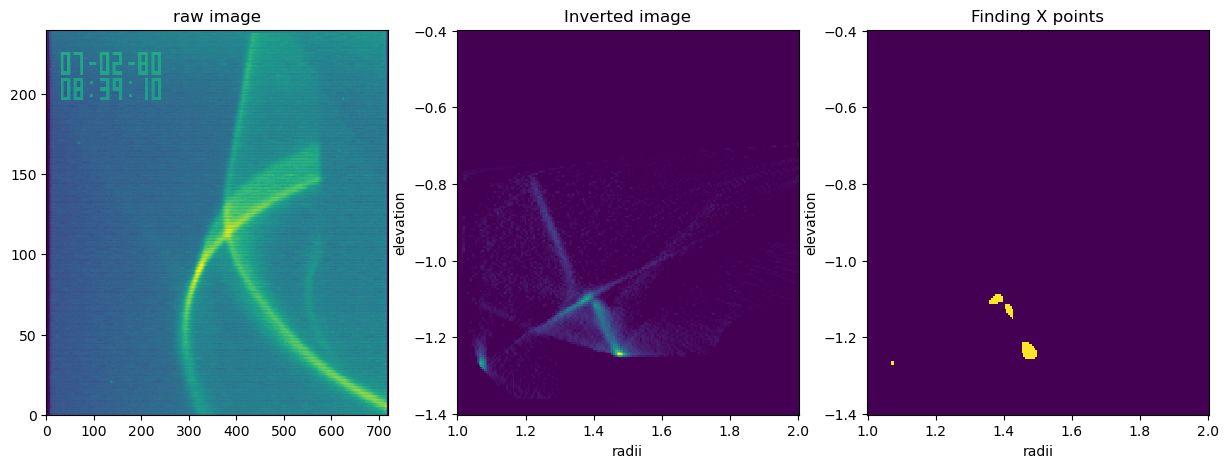

In [5]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
fid =110
tid = _find_index(vid_times,times[fid]) #find frame id for camera image with t=times[fid]

find_x = inverted[fid]
find_x = find_x/7.5 # max value of inverted in whole dataset

find_x = np.power(find_x,2)

gaussblr_win = (11,11) # Gaussian blur filter size
find_x =  gaussblr(find_x,gaussblr_win)
find_x = meansub(find_x)    
# Sxx_enhanced = morph(Sxx_enhanced)
# Sxx_enhanced = meansub(Sxx_enhanced)
find_x  = np.where(find_x<0.3,0,1) # Threshold of 0.3 to detect spot


ax[0].pcolormesh(vid[fid][::-1,:])
ax[0].set(title='raw image')
ax[1].pcolormesh(radii[fid],elevation[fid],inverted[fid],shading='auto')
ax[1].set(title='Inverted image',xlabel='radii',ylabel='elevation')
ax[2].pcolormesh(radii[fid],elevation[fid],find_x,shading='auto')
ax[2].set(title='Finding X points',xlabel='radii',ylabel='elevation')
plt.plot()

### Edge Detection

[[ 1.485 -1.245]
 [ 1.08  -1.28 ]
 [ 1.39  -1.095]]


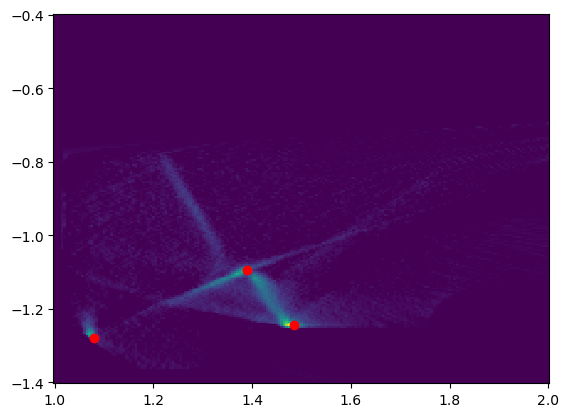

In [6]:
img = inverted[fid].copy()
gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')
useHarrisDetector = False # False uses Shi-Tomasi Corner Detector
corners = cv2.goodFeaturesToTrack(gray,3,0.01,10, useHarrisDetector=useHarrisDetector)
corners = np.intp(corners)
x = radii[fid][corners[:,0,0]]
y = elevation[fid][corners[:,0,1]]
print(np.column_stack((x,y)))
plt.pcolormesh(radii[fid],elevation[fid],img,shading='auto')
plt.scatter(x,y,color='red')
plt.show()

### Detecting lines in raw image (lines correspond to XPR and Emission Front)


In [7]:
img = np.sqrt(vid[tid]).copy()
gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')

# reduce the noise using Gaussian filters
kernel_size = 11 
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Apply Canny edge detctor
low_threshold = 10
high_threshold = 20
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Apply Hough transform
rho = 1  # This is the distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments
line_image = np.zeros((img.shape[0],img.shape[1],3))  # creating a blank to draw lines on


lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) # The output "lines" is an array containing endpoints of detected line segments

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

        
line_len=[]
for line in lines:
    for x1,y1,x2,y2 in line:
        line_len.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
        
# add the line_image as an extra layer on top of the original image
lines_edges = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 1, line_image, 0.5, 0,dtype =0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Text(0.5, 1.0, 'Final result')]

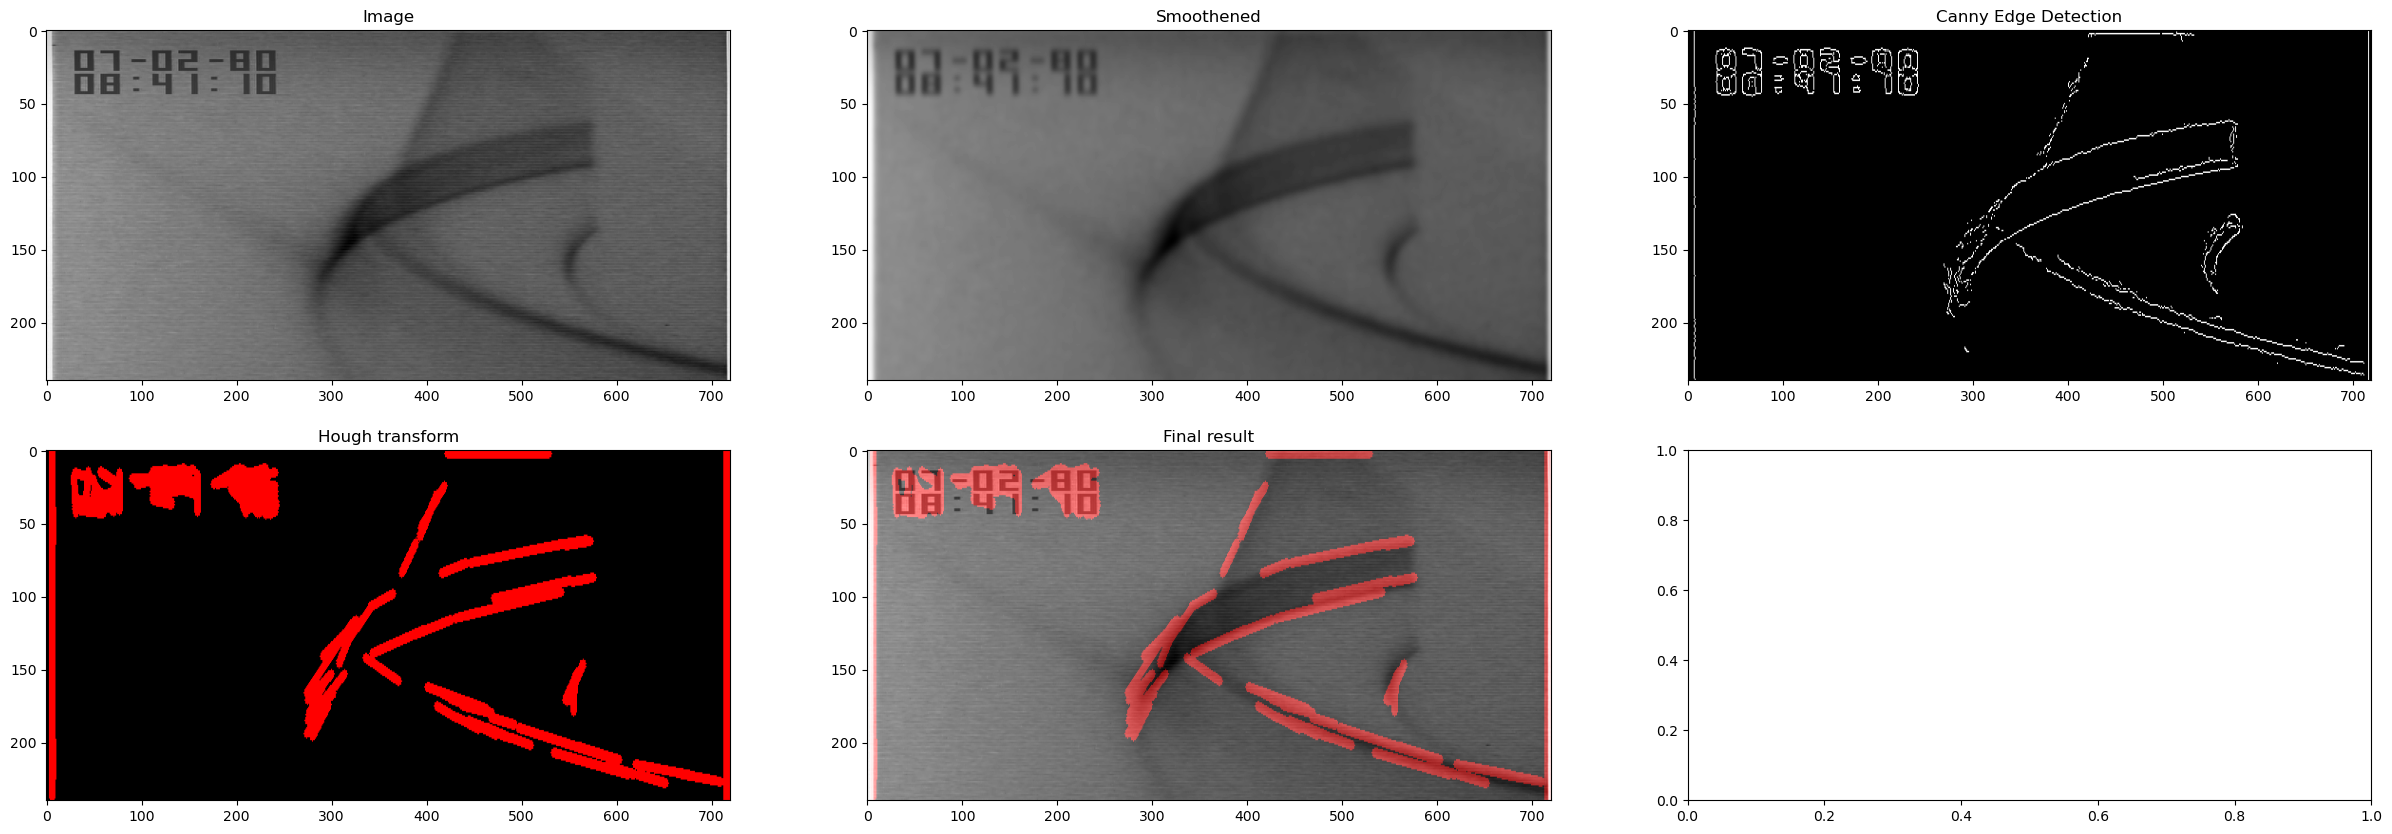

In [8]:
# plots
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(30,10))


ax[0,0].imshow(gray,cmap='gray',aspect='auto')
ax[0,0].set(title='Image')

ax[0,1].imshow(blur_gray,cmap='gray',aspect='auto')
ax[0,1].set(title='Smoothened')

ax[0,2].imshow(edges,cmap='gray',aspect='auto')
ax[0,2].set (title='Canny Edge Detection')

ax[1, 0].imshow(line_image,cmap='gray',aspect='auto')
ax[1, 0].set(title='Hough transform')



ax[1, 1].imshow(lines_edges,aspect='auto')
ax[1, 1].set(title='Final result')


### Reconstruction
doi: 10.1109/TPS.2018.2828863.

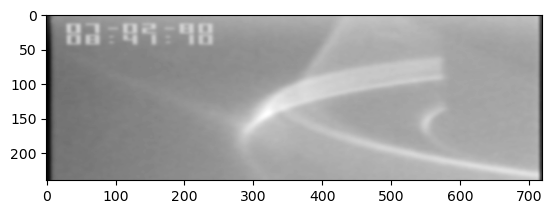

In [162]:
img = np.sqrt(vid[tid]).copy()# [150:200,400:500]
ratio = np.amax(img) / 255
img8 = (img/ratio).astype('uint8')
kernel_size = 11
blur_gray = cv2.GaussianBlur(img8,(kernel_size, kernel_size),0)

# img = cv2.imread('zhang4ab-2828863-large.jpg')
# img8 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[100:200,100:200]

plt.imshow(blur_gray, cmap='gray')

In [213]:
def get_probability(img):
    
    gamma = 255
    alpha = .5
    
    img = img / gamma
    dim = img.shape
    totdim = dim[0] * dim[1]
    im_ave = np.average(img)

    significance = np.zeros_like(img)

    for i in range(dim[0]):
        for j in range(dim[1]):
            significance[i,j] = totdim * np.log(img[i,j]+1) * (img[i,j] - im_ave * alpha)
            
    return significance / significance.max()

def prob_to_edge(img):
    delta = 0.01
    ksize = 5
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    edge_grad = np.sqrt(sobelx**2 + sobely**2)
    dim = edge_grad.shape
    edge = np.zeros_like(img)
    for i in range(dim[0]):
        for j in range(dim[1]):
            edge[i,j] = 255 * (edge_grad[i,j] < delta)
    return edge_grad

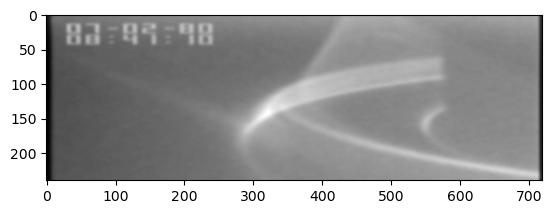

In [214]:
probability = get_probability(blur_gray)
plt.imshow(probability, cmap='gray')
plt.show()

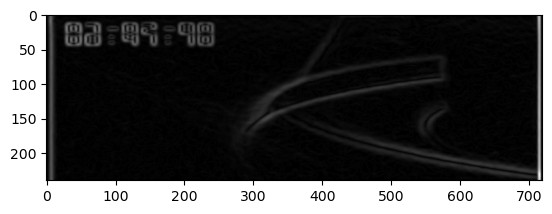

In [217]:
edge = prob_to_edge(probability)
plt.imshow(edge, cmap='gray')
plt.show()

In [185]:
rho = 1  # This is the distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments
line_image = np.zeros((img.shape[0],img.shape[1],3))  # creating a blank to draw lines on


lines = cv2.HoughLinesP(edge, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) # The output "lines" is an array containing endpoints of detected line segments

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

        
line_len=[]
for line in lines:
    for x1,y1,x2,y2 in line:
        line_len.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
        
# add the line_image as an extra layer on top of the original image
lines_edges = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 1, line_image, 0.5, 0,dtype =0)

error: OpenCV(4.6.0) C:\ci_311_rebuilds\opencv-suite_1679001454889\work\modules\imgproc\src\hough.cpp:473: error: (-215:Assertion failed) image.type() == CV_8UC1 in function 'cv::HoughLinesProbabilistic'


### Training a model to predict X point coordinates based on synthetic XPR

In [17]:
data = pickle.load(open('/projects/EKOLEMEN/plasmatv_data/synthetic_data/synthetic_outs.pl','rb'))
X=np.int_(np.dstack([v for k,v in data['image'].items()]))
y=np.dstack([v for k,v in data['RZ'].items()])

rand_ind=np.random.permutation(X.shape[2])

X_train = X[:,:,rand_ind[:1000]]
y_train = y[:,:,rand_ind[:1000]]

X_valid = X[:,:,rand_ind[1000:1500]]
y_valid = y[:,:,rand_ind[1000:1500]]

X_test = X[:,:,rand_ind[1500:]]
y_test = y[:,:,rand_ind[1500:]]

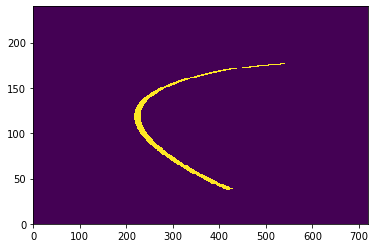

In [20]:
plt.pcolormesh(X_train[:,:,100])

### Task 1: Train a model to predict a single X point using XPR synthetic data

### Task 2: Load the syntheitc data (synthetic_outs_2d_ver2.pl) for both XPR and Emission Front and train a model to detect both inner and outer X points

### Task 3: Detect the XPR and Emission Front in the raw image and redo Task 1&2 but with the detected lines rather than synthetic data